# Depth Filtration Sensitivity Study

##### Brendon Pearlman, Shu Zhu, Yingge Liu

### Table of Contents
1. [Parameter Visualization - OAT Approach](#One-At-A-Time-Approach)
1. [Large-Scale Visualization](#Large-Scale-Parameter-Visualization)
1. [Sobol Analysis](#Sobol-Analysis)
1. [Summary](#Summary)

In [ ]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from ipywidgets import widgets, interact
from IPython.display import display
import pandas as pd
import seaborn as sns
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from IPython.core.pylabtools import figsize

## One-At-A-Time Approach

In [5]:
L = 2.
Lspan = np.linspace(0,L)
C0 = 50.

@interact(stream_velocity=widgets.FloatSlider(description='Velocity',value=10, min=1, max=50, step=2),
          solids_diameter=widgets.FloatSlider(description='Solids D',value=1.4,min=.1,max=5,step=.1),
          initial_bed_porosity=widgets.FloatSlider(description='Bed Porosity', value=.4,min=.05,max=1,step=.05),
          creep_constant=widgets.FloatSlider(description='Creep Factor',value=1.145,min=.05,max=3,step=.25))

def interaction(stream_velocity,
                solids_diameter,
                initial_bed_porosity,
                creep_constant):

    def my_function(C,L,
                    stream_velocity,
                    solids_diameter,
                    initial_bed_porosity,
                    creep_constant):
        """
        Calculates concentration of suspended particles as a function
            of depth in filtration bed

        Inputs:
            > Time, t
            > Depth, L
            > Pore Saturation
            > Initial Bed Porosity
            > Flow velocity
            > Psi Constant
            > Creep Constant

        Outputs:
            > Concentration at given depth in bed
        """
        psi_constant=0.95
        
        pore_saturation = (6 * (1-initial_bed_porosity)) / (psi_constant * solids_diameter)

        filter_coefficient = creep_constant * ((pore_saturation**1.35) / (stream_velocity**.25)) 

        dCdL = -filter_coefficient * C
        return dCdL
    
    sol = odeint(my_function, 50., Lspan, args=(stream_velocity,
                                                solids_diameter,
                                                initial_bed_porosity,
                                                creep_constant))
    
    plt.plot(Lspan, sol, 'b.-')
    plt.xlabel('Depth in Bed')
    plt.ylabel('Concentration of Suspended Particles')
    plt.title('Suspended Particle Concentration through Packed Filtration Bed')
    plt.show()
    
    print("The concentration of particles at the filter's outlet is: {} g/m3".format(round(np.amin(sol),5)))
    
    return

interactive(children=(FloatSlider(value=10.0, description='Velocity', max=50.0, min=1.0, step=2.0), FloatSlide…

In [6]:
# Length of depth filter
L = 2.
Lspan = np.linspace(0,L)
C0 = 50. # Initial particle concentration

def my_function(C, L, stream_velocity, solids_diameter,
                initial_bed_porosity, creep_constant):
    """
    Takes given arguments and returns a concentration gradient over the depth filter
    """
    psi_constant=0.95
    pore_saturation = (6 * (1-initial_bed_porosity)) / (psi_constant * solids_diameter)
    filter_coefficient = creep_constant * ((pore_saturation**1.35) / (stream_velocity**.25)) 
    dCdL = -filter_coefficient * C
    return dCdL

def odefun(v,d,p,c):
    """
    Integrates my_function over given span, supplying arguments accordingly.  Outputs minimum concentration,
        which correspondends to the concentration of particles at the end of the filter.
    """
    sol = odeint(my_function, C0, Lspan, args=(v,d,p,c))
    end_concentration = np.amin(sol)
    return end_concentration

## Large-Scale Parameter Visualization

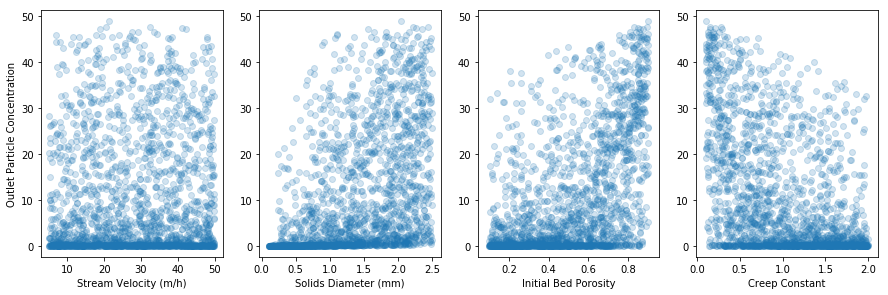

In [14]:
number_sims = 2000 # Iterations to run for sampling
data = []
mc_velocity = []
mc_diameter = []
mc_porosity = []
mc_creep = []

# Loops through sampling range
for i in range(0,number_sims,1):
    
    # Random numbers generated for each argument upon each new iteration
    v = np.random.uniform(5,50,1)
    d = np.random.uniform(.1,2.5,1)
    p = np.random.uniform(.1,.9,1)
    c = np.random.uniform(.1,2,1)    
    
    # Update list with most recent calculated concentration at outlet
    data.append(odefun(v,d,p,c))
    
    # Update lists with random-generated value
    mc_velocity.append(v)
    mc_diameter.append(d)
    mc_porosity.append(p)
    mc_creep.append(c)

# Converts all lists to arrays for later use
data = np.asarray(data)
mc_velocity = np.asarray(mc_velocity)
mc_diameter = np.asarray(mc_diameter)
mc_porosity = np.asarray(mc_porosity)
mc_creep = np.asarray(mc_creep)

# Plotting of relevant arrays with respect to generate concentration data
figsize(15, 10)
plt.subplot(241)
plt.scatter(mc_velocity, data, alpha=0.2)
plt.ylabel('Outlet Particle Concentration')
plt.xlabel('Stream Velocity (m/h)')
plt.subplot(242)
plt.scatter(mc_diameter, data, alpha=0.2)
plt.xlabel('Solids Diameter (mm)')
plt.subplot(243)
plt.scatter(mc_porosity, data, alpha=0.2)
plt.xlabel('Initial Bed Porosity')
plt.subplot(244)
plt.scatter(mc_creep, data, alpha=0.2)
plt.xlabel('Creep Constant')
plt.show()
#plt.savefig('scatter.png')

In [5]:
import SALib
from SALib.sample import morris as ms
from SALib.analyze import morris as ma
from SALib.plotting import morris as mp
from SALib.sample import saltelli as ss
from SALib.analyze import sobol as sb

## Sobol Analysis

In [6]:
problem = {
    # There are four variables being tested
    'num_vars': 4,
    'names': ['Velocity', 'Solids Diameter', 'Initial Porosity', 'Creep Constant'],
    # Bounds for each parameter based on reasonable ranges
    'bounds': [[5,50], # Stream velocity (m/h)
               [.1,2.5], # Solids diameter (mm)
               [.1,.9], # Initial bed porosity
               [.1,2], # Creep constant
              ],
    'groups': None
    }

In [7]:
num_levels = 4
grid_jump = 2
trajectories = int(1e4)
sample = ms.sample(problem, trajectories, num_levels, grid_jump)
sample = sample.T

In [8]:
param_values = ss.sample(problem,10000)
param_values = param_values.T
param_values.shape

(4, 100000)

In [9]:
Y = []

# Loops through range, calculating concentration with each sample value
for x in range(0,100000,1):
    Y.append(odefun(param_values[0,x],param_values[1,x],
                    param_values[2,x],param_values[3,x]))
    
Y = np.asarray(Y)
print(Y.shape)
print(Y)

(100000,)
[-4.69116420e-10 -4.68257772e-10  6.08422515e+00 ...  2.11050572e+00
  2.46775890e+01  1.95353858e+01]


In [10]:
Si = sb.analyze(problem,Y,print_to_console=False)

print("{:28s} {:>5s} {:>5s} {:>12s}".format("Name", "1st", "Total", "Mean of Input"))
for name, s1, st, mean in zip(problem['names'], Si['S1'], Si['ST'], sample.mean(axis=0)):
    print("{:28s} {:=5.2f} {:=5.2f} ({:=12.2f})".format(name, s1, st, mean))

Name                           1st Total Mean of Input
Velocity                      0.01  0.01 (        9.45)
Solids Diameter               0.23  0.38 (        1.95)
Initial Porosity              0.32  0.43 (        2.08)
Creep Constant                0.28  0.38 (        1.68)


In [11]:
means = sample.mean(0)
means[0:4]

array([9.45      , 1.95      , 2.08333333, 1.68333333])

In [12]:
cm = sns.light_palette("teal", as_cmap=True)

df = pd.DataFrame({'Name': problem['names'], '1st Order':Si['S1'], 
                   'Total':Si['ST'], 'Mean of Input':means[0:4]})

with pd.option_context('display.precision', 4):
    s = (df.style\
       .set_properties(**{'text-align': 'center'})\
       .set_caption('')\
       .hide_index()\
       .background_gradient(cmap=cm))
s

Name,1st Order,Total,Mean of Input
Velocity,0.007547,0.01428,9.45
Solids Diameter,0.2259,0.3794,1.95
Initial Porosity,0.3177,0.4313,2.083
Creep Constant,0.278,0.3759,1.683


## Summary

* All parameters have important 1st order effects, however **Velocity** appears to have more important interaction effects.
* **Initial Bed Porosity** is the most important parameter, followed by **Solids Diameter** and the **Creep Constant**
* **Velocity** is the lest important parameter
* The Sobol analysis results were expected based on behavior in the large-scale analysis showing density distrubution of a 2000-sample model output.